In [826]:
import json
import joblib
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer

import catboost
import torch

# Задание - Предсказание уровня экспресси белка

<img src='https://www.researchgate.net/publication/313504607/figure/fig3/AS:459880453677066@1486655453033/Protein-protein-interaction-PPI-network-of-DEGs-by-STRING-The-interaction-score-was.png'>




<div class="alert alert-info">
<b>Про биологию</b>
    
Экспрессия — процесс, в ходе которого наследственная информация от гена (последовательности нуклеотидов ДНК) преобразуется в функциональный продукт — белок. Уровнем экспрессии называют - количество белка, производящегося в этом процессе. Чем выше экспрессия белка, тем большее количество этого белка появляется в клетках человека. 
    
    

<div class="alert alert-info">    
<b>Важность задачи</b>
    
Существует множество причин необходимости в знании уровня экспресии белка. Например - это позволяет ученым разрабатывать лекарственные средства и оптимизировать их разработку. Теперь вам предстоит побыть в роли биоинформатика и помочь науке!
    
</div>


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой граф взаимойдествия белков. Где узлы это белки, взаимодействие между белками это ребро. 

Для каждого белка известен уровень его экспрессии. Ниже приведен список ребер `edges`. Информация по экспрессии белков, разбитая на `train` и `test`.
   
    
</div>

In [2]:
#Список ребер графа 

edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",") # Подгрузим данные
edges.head()

,node_1,node_2
0,344,50
1,344,153
2,344,532
3,344,679
4,344,986


In [3]:
#Подгрузим тренирочную выборку
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv", sep=",") # Подгрузим данные
train.head()

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514
3,0.272500,20944
4,0.248888,8721


In [4]:
# Подгрузим отложенную выборку для валидации
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv", sep=",")
test.head()

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607
3,0.303594,4782
4,0.367374,24125


<div class="alert alert-info">
<b>Про Задачу</b>
    
Вам предлагается предсказать экспрессию белков (`target`) по приведенным данным для отложенной выборки. Ответы в отложенной выборке `test` даны вам для самостоятельной валидации.


    
   
    

<div class="alert alert-info">
<b>Замечание и комментарии</b>
    
    

По ряду причин датасет был упрощен так, чтобы выполнялись следующие условия:
* у графа одна компонента связанности. 
* удалены слишком крупные хабы
* плотность связей графа уменьшена
* решить задачу можно классическими ML подходами
    
   

<div class="alert alert-info">
<b>Оценка результатов</b>
    


Оценка точности модели будет оцениваться по метрике MSE на отложенной выборке `test`
        
</div>

<div class="alert alert-info">
<b>Автор задачи</b>

По всем дополнительным вопросами писать Александру Миленькину
* Телеграмм: Alerin75infskin
* Почта: milenkin.aa@phystech.edu
        
</div>

### Make graph

In [24]:
edges.shape

(594174, 2)

In [21]:
gr = nx.Graph()
gr.add_edges_from(edges.to_numpy())

In [23]:
gr.number_of_edges()

594174

In [27]:
len(gr.nodes())

10000

In [43]:
sorted(gr.nodes())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 20,
 22,
 24,
 25,
 27,
 28,
 29,
 31,
 32,
 34,
 35,
 39,
 41,
 42,
 44,
 45,
 46,
 49,
 50,
 54,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 73,
 74,
 76,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 103,
 104,
 105,
 106,
 108,
 109,
 110,
 112,
 113,
 114,
 116,
 118,
 120,
 122,
 126,
 127,
 131,
 133,
 134,
 136,
 137,
 138,
 140,
 145,
 146,
 150,
 151,
 153,
 156,
 158,
 159,
 162,
 163,
 166,
 167,
 168,
 169,
 170,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 184,
 186,
 188,
 190,
 194,
 195,
 198,
 199,
 200,
 202,
 204,
 205,
 207,
 208,
 210,
 211,
 212,
 213,
 214,
 218,
 220,
 221,
 222,
 224,
 225,
 226,
 227,
 230,
 231,
 232,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 246,
 247,
 249,
 250,
 251,
 254,
 257,
 258,
 260,
 263,
 264,
 265,
 267,
 268,
 269,
 270,
 27

In [36]:
min_node_num = edges.values.min()
min_node_num = edges.values.max()

In [51]:
nodes_mapping = {k: node for k, node in enumerate(sorted(gr.nodes()))}
nodes_mapping_rev = {node: k for k, node in enumerate(sorted(gr.nodes()))}

In [52]:
nodes_mapping_rev

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 20: 16,
 22: 17,
 24: 18,
 25: 19,
 27: 20,
 28: 21,
 29: 22,
 31: 23,
 32: 24,
 34: 25,
 35: 26,
 39: 27,
 41: 28,
 42: 29,
 44: 30,
 45: 31,
 46: 32,
 49: 33,
 50: 34,
 54: 35,
 57: 36,
 58: 37,
 59: 38,
 60: 39,
 61: 40,
 62: 41,
 63: 42,
 65: 43,
 66: 44,
 67: 45,
 68: 46,
 69: 47,
 70: 48,
 71: 49,
 73: 50,
 74: 51,
 76: 52,
 78: 53,
 79: 54,
 80: 55,
 81: 56,
 82: 57,
 83: 58,
 84: 59,
 85: 60,
 86: 61,
 87: 62,
 88: 63,
 90: 64,
 91: 65,
 92: 66,
 94: 67,
 95: 68,
 96: 69,
 97: 70,
 98: 71,
 99: 72,
 100: 73,
 101: 74,
 103: 75,
 104: 76,
 105: 77,
 106: 78,
 108: 79,
 109: 80,
 110: 81,
 112: 82,
 113: 83,
 114: 84,
 116: 85,
 118: 86,
 120: 87,
 122: 88,
 126: 89,
 127: 90,
 131: 91,
 133: 92,
 134: 93,
 136: 94,
 137: 95,
 138: 96,
 140: 97,
 145: 98,
 146: 99,
 150: 100,
 151: 101,
 153: 102,
 156: 103,
 158: 104,
 159: 105,
 162: 106,
 163: 107,
 166:

In [53]:
# некоторые параметры визауализации графа
node_size = 600
with_labels=True
node_color="r"
# отрисовка графа
plt.figure(figsize=(10,10))
nx.draw_networkx(gr,
                 pos=nx.kamada_kawai_layout(gr), # вариант макета укладки графа
                 with_labels=with_labels, # добавление меток к варшинам графа
                 node_size=node_size, # размер узлов
                 node_color=node_color, # цвет узлов
                 labels=nodes_mapping_rev # маркировка вершин их атрибутами
                 )
plt.axis("off")
plt.show()

KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

In [70]:
degrees = dict(gr.degree)
degrees = dict(sorted(degrees.items(), key=lambda x: x[0]))

In [72]:
clustering_coefs = nx.clustering(gr)
clustering_coefs = dict(sorted(clustering_coefs.items(), key=lambda x: x[0]))

In [152]:
degree_centrality = nx.degree_centrality(gr)
degree_centrality = dict(sorted(degree_centrality.items(), key=lambda x: x[0]))

In [181]:
betweenness_centrality = nx.betweenness_centrality(gr)
betweenness_centrality = dict(sorted(betweenness_centrality.items(), key=lambda x: x[0]))

In [183]:
closeness_centrality = nx.closeness_centrality(gr)
closeness_centrality = dict(sorted(closeness_centrality.items(), key=lambda x: x[0]))

In [584]:
eigenvector_centrality = nx.eigenvector_centrality(gr)
eigenvector_centrality = dict(sorted(eigenvector_centrality.items(), key=lambda x: x[0]))

In [603]:
information_centrality = nx.current_flow_closeness_centrality(gr)
information_centrality = dict(sorted(information_centrality.items(), key=lambda x: x[0]))

In [604]:
# TODO: 5 - binning; 6 - drop outliers 

In [235]:
cliques = list(nx.find_cliques(gr))

In [254]:
cliques

[[0, 20480, 1538],
 [0, 20480, 9747, 569],
 [0, 20480, 27432],
 [0, 20480, 13628, 1378, 574],
 [0, 20480, 13628, 1768],
 [0, 20480, 13628, 2122],
 [0, 20480, 13628, 2898],
 [0, 20480, 13628, 569, 1309],
 [0, 20480, 13628, 2204],
 [0, 20480, 4031],
 [0, 20480, 26563, 569],
 [0, 20480, 8006],
 [0, 20480, 5065, 24919],
 [0, 20480, 4684],
 [0, 20480, 18261, 1378],
 [0, 20480, 4566],
 [0, 20480, 24919, 3683],
 [0, 20480, 3803],
 [0, 20480, 21090],
 [0, 20480, 3683, 1768],
 [0, 20480, 3683, 569],
 [0, 20480, 3683, 2122],
 [0, 20480, 9192],
 [0, 20480, 23531, 1768],
 [0, 20480, 23531, 569],
 [0, 20480, 9328],
 [0, 20480, 13681],
 [0, 20480, 24188, 2122],
 [0, 1, 18433],
 [0, 1, 14857, 3713],
 [0, 1, 14857, 900, 4328],
 [0, 1, 14857, 900, 1003],
 [0, 1, 14857, 2122, 122],
 [0, 1, 14857, 1854, 4328],
 [0, 1, 14857, 1854, 16189],
 [0, 1, 14857, 1854, 2559],
 [0, 1, 26123, 1768],
 [0, 1, 26123, 1854],
 [0, 1, 23054, 1854],
 [0, 1, 23054, 25266, 87],
 [0, 1, 23054, 9295, 1768],
 [0, 1, 23054, 9295

In [251]:
nodes = [x for x in gr]

In [286]:
cnt_cliques_0 = {n: sum(1 for c in cliques if n in c) for n in tqdm(nodes[:10])}

100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


In [289]:
cnt_cliques_0[344], cnt_cliques[344]

(178, 178)

In [288]:
cnt_cliques = {}
max_cliques = {}
for cl in tqdm(cliques):
    for n in cl:
        len_cl = len(cl)
        curr_cnt = cnt_cliques.get(n, 0)
        curr_max = max_cliques.get(n, 0)
        if len_cl > curr_max:
            max_cliques[n] = len_cl
        cnt_cliques[n] = curr_cnt + 1
cnt_cliques = dict(sorted(cnt_cliques.items(), key=lambda x: x[0]))
max_cliques = dict(sorted(max_cliques.items(), key=lambda x: x[0]))

  0%|          | 0/1266891 [00:00<?, ?it/s]

100%|██████████| 1266891/1266891 [00:03<00:00, 332547.77it/s]


In [291]:
len(max_cliques), len(cnt_cliques)

(10000, 10000)

In [297]:
cnt_cliques

{0: 25362,
 1: 14374,
 2: 25369,
 3: 128,
 4: 49,
 5: 4079,
 6: 2286,
 7: 2141,
 8: 127,
 9: 342,
 10: 12475,
 12: 31872,
 13: 7789,
 14: 1147,
 15: 2727,
 16: 42223,
 20: 425,
 22: 141,
 24: 267,
 25: 14575,
 27: 143,
 28: 769,
 29: 159,
 31: 1241,
 32: 17135,
 34: 127,
 35: 7606,
 39: 48,
 41: 124,
 42: 5344,
 44: 254,
 45: 892,
 46: 150,
 49: 19365,
 50: 3062,
 54: 144,
 57: 72,
 58: 182,
 59: 55,
 60: 750,
 61: 7712,
 62: 2089,
 63: 1527,
 65: 61,
 66: 57,
 67: 133,
 68: 907,
 69: 71,
 70: 52,
 71: 1515,
 73: 1675,
 74: 464,
 76: 8466,
 78: 715,
 79: 368,
 80: 8415,
 81: 2855,
 82: 1725,
 83: 6692,
 84: 1650,
 85: 58,
 86: 1056,
 87: 81523,
 88: 4034,
 90: 2389,
 91: 8872,
 92: 269,
 94: 941,
 95: 17153,
 96: 6261,
 97: 11848,
 98: 3316,
 99: 966,
 100: 1350,
 101: 329,
 103: 62,
 104: 70,
 105: 218,
 106: 1728,
 108: 48374,
 109: 6749,
 110: 4577,
 112: 12569,
 113: 231,
 114: 139,
 116: 451,
 118: 171,
 120: 998,
 122: 10879,
 126: 1721,
 127: 501,
 131: 130,
 133: 76,
 134: 81,


In [292]:
max_cliques.keys() == closeness_centrality.keys()

True

In [573]:
bridges = list(nx.bridges(gr))

In [574]:
bridges

[]

In [ ]:
community = list(nx.algorithms.community.girvan_newman(gr))

In [578]:
conn_components = list(nx.connected_components(gr))

In [582]:
len(conn_components[0])

10000

In [816]:
features = {
                                                    'degree': degrees.values(),
                                                    'clustering_coef': clustering_coefs.values(),
                                                    'degree_centrality': degree_centrality.values(),
                                                    'betweenness_centrality': betweenness_centrality.values(),
                                                    'closeness_centrality': closeness_centrality.values(),
                                                    'eigenvector_centrality': eigenvector_centrality.values(),
                                                    # 'information_centrality': information_centrality.values(),
                                                    'cnt_cliques': cnt_cliques.values(),
                                                    'max_cliques': max_cliques.values(),
                                                }
features_full = {
                                                    'degree': degrees,
                                                    'clustering_coef': clustering_coefs,
                                                    'degree_centrality': degree_centrality,
                                                    'betweenness_centrality': betweenness_centrality,
                                                    'closeness_centrality': closeness_centrality,
                                                    'eigenvector_centrality': eigenvector_centrality,
                                                    'information_centrality': information_centrality,
                                                    'cnt_cliques': cnt_cliques,
                                                    'max_cliques': max_cliques,
                                                }

In [817]:
data = pd.DataFrame(index=degrees.keys(), data=features)

In [778]:
joblib.dump(features_full, './data/extracted_features.pkl')

['./data/extracted_features.pkl']

In [228]:
extracted_features = joblib.load('./data/extracted_features.pkl')

In [232]:
max(extracted_features['betweenness_centrality'].keys())

31204

In [223]:
data.to_csv('./data/data_prepared.csv', index=False)

### Train model

<Axes: >

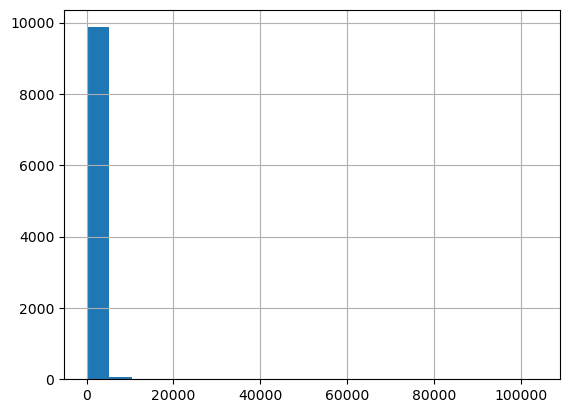

In [654]:
data.cnt_cliques.hist(bins=20)

In [818]:
data.corr()

,degree,clustering_coef,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,cnt_cliques,max_cliques
degree,1.000000,-0.212480,1.000000,0.870482,0.576371,0.917283,0.776371,0.485445
clustering_coef,-0.212480,1.000000,-0.212480,-0.134779,0.330783,0.051441,-0.069533,0.452767
degree_centrality,1.000000,-0.212480,1.000000,0.870482,0.576371,0.917283,0.776371,0.485445
betweenness_centrality,0.870482,-0.134779,0.870482,1.000000,0.368194,0.768685,0.852784,0.312556
closeness_centrality,0.576371,0.330783,0.576371,0.368194,1.000000,0.750191,0.359052,0.808274
eigenvector_centrality,0.917283,0.051441,0.917283,0.768685,0.750191,1.000000,0.735649,0.698020
cnt_cliques,0.776371,-0.069533,0.776371,0.852784,0.359052,0.735649,1.000000,0.348171
max_cliques,0.485445,0.452767,0.485445,0.312556,0.808274,0.698020,0.348171,1.000000


In [638]:
data = data.drop(columns=['degree'])

In [888]:
X_train = data[data.index.isin(train.node)].sort_index()
y_train = train.sort_values('node').target
X_test = data[data.index.isin(test.node)]
y_test = test.sort_values('node').target

In [820]:
X_train

,degree,clustering_coef,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,cnt_cliques,max_cliques
0,1863,0.013900,0.186319,0.010784,0.551274,0.071758,25362,8
1,804,0.036914,0.080408,0.002156,0.519078,0.038140,14374,7
2,1709,0.014655,0.170917,0.007632,0.546244,0.069276,25369,8
3,55,0.111785,0.005501,0.000014,0.440873,0.003467,128,5
4,52,0.025641,0.005201,0.000009,0.394360,0.002144,49,4
...,...,...,...,...,...,...,...,...
31175,42,0.011614,0.004200,0.000008,0.383559,0.001560,41,3
31178,206,0.006583,0.020602,0.000150,0.432333,0.006553,223,4
31179,47,0.031452,0.004700,0.000005,0.383397,0.002239,48,4
31193,90,0.014232,0.009001,0.000021,0.403886,0.003852,103,3


In [821]:
train.sort_values('node')

,target,node
6438,8.247335,0
4727,3.061097,1
4915,7.630718,2
3184,0.266202,3
6836,0.261948,4
...,...,...
6284,0.214446,31175
2517,0.871948,31178
5892,0.241908,31179
4760,0.384346,31193


In [822]:
bin_d = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')

lr = LinearRegression(
                        fit_intercept=True
                        )
el_n = ElasticNet()
rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=8,
    max_features=2,
    # min_samples_split=2,
    # min_samples_leaf=4,
    random_state=42,
)
svr = SVR()
cb = catboost.CatBoostRegressor(
                                    iterations=50,
                                    # objective='MSE',
                                    max_depth=4,
                                    l2_leaf_reg=2,
                                    )
pipeline = Pipeline(
                        [
                            ('scaler', StandardScaler()), 
                            # ('discretizer', bin_d), 
                            # ('sclaler', MinMaxScaler()), 
                            ('lr', lr),
                            # ('elastic_net', el_n),
                            # ('random forest', rf),
                            # ('catboost', cb),
                            # ('SVR', svr),
                        ]
                    )

In [823]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [824]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

In [825]:
print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred)}")

print(f"Train MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred)}")

print(f"Train RMSE: {root_mean_squared_error(y_train, y_train_pred)}")
print(f"Test RMSE: {root_mean_squared_error(y_test, y_test_pred)}")

print(f"Train R2: {r2_score(y_train, y_train_pred)}")
print(f"Test R2: {r2_score(y_test, y_test_pred)}")

Train MAE: 0.05366250781675475
Test MAE: 0.05402755877146817
Train MSE: 0.008509103876922212
Test MSE: 0.010459472073959112
Train RMSE: 0.09224480406463126
Test RMSE: 0.1022715604357297
Train R2: 0.9812112485355575
Test R2: 0.9860926963907628


In [770]:
(np.abs(y_test - y_test_pred) / y_test).mean() * 100

10.414415019892852

### Best

In [ ]:
print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred)}")

print(f"Train MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred)}")

print(f"Train RMSE: {root_mean_squared_error(y_train, y_train_pred)}")
print(f"Test RMSE: {root_mean_squared_error(y_test, y_test_pred)}")

print(f"Train R2: {r2_score(y_train, y_train_pred)}")
print(f"Test R2: {r2_score(y_test, y_test_pred)}")

Train MAE: 0.053662507816754766
Test MAE: 0.05402755877146819
Train MSE: 0.008509103876922214
Test MSE: 0.010459472073959144
Train RMSE: 0.09224480406463127
Test RMSE: 0.10227156043572985
Train R2: 0.9812112485355575
Test R2: 0.9860926963907628


In [ ]:
(np.abs(y_test - y_test_pred) / y_test).mean() * 100

11.127834137290368

### Neural net

In [889]:
X_train = torch.Tensor(StandardScaler().fit_transform(X_train))
y_train = torch.Tensor(y_train.to_numpy()).reshape((-1,1))
X_test = torch.Tensor(StandardScaler().fit_transform(X_test))
y_test = torch.Tensor(y_test.to_numpy()).reshape((-1,1))

In [890]:
y_train.shape

torch.Size([8000, 1])

In [909]:
class NeuralNet(torch.nn.Module):
    def __init__(self,
                    n_hidden_neurons: dict,
                    ):
        super().__init__()
        self.n_hidden_neurons = n_hidden_neurons
        self.blocks = []
        for _, num_nn in self.n_hidden_neurons.items():            
            self.blocks.append(torch.nn.Linear(num_nn[0], num_nn[1]))  
            self.blocks.append(torch.nn.ReLU())
            self.blocks.append(torch.nn.Dropout(0.7))
        self.blocks.append(torch.nn.Linear(num_nn[1], 1))
        self.core_layers = torch.nn.Sequential(*self.blocks)
    
    def forward(self, x):
        for block in self.core_layers:
            x = block(x)
        return x

In [979]:
nn = NeuralNet(
    {
        '0': (X_train.shape[1], 100),
        # '1': (100, 10)
    }
)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nn.parameters(), lr=1e-03)

In [981]:
BATCH_SIZE = 32
EPOCHS = 40

In [982]:
for iteration in range(EPOCHS):
    order = np.random.permutation(X_train.shape[0])
    X_train = X_train[order]
    y_train = y_train[order]
    num_batches = X_train.shape[0] // BATCH_SIZE
    for batch in range(0, num_batches + 1):
        X_batch = X_train[batch*BATCH_SIZE:(batch + 1)*BATCH_SIZE]
        y_batch = y_train[batch*BATCH_SIZE:(batch + 1)*BATCH_SIZE]            
        optimizer.zero_grad()                        
        preds = nn(X_batch)
        loss_batch = loss(preds, y_batch)
        loss_batch.backward()
        optimizer.step()
    if iteration % 10 == 0:
        with torch.no_grad():
            y_pred = nn(X_train)
            mse = mean_squared_error(y_train, y_pred)
            print(f"Epoch {iteration}, MSE: {mse}")
with torch.no_grad():
    y_test_pred = nn.eval()(X_test)
    y_train_pred = nn.eval()(X_train)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    print(f"MSE (train): {mse_train}")
    print(f"MSE (test): {mse_test}")


Epoch 0, MSE: 0.11144106090068817
Epoch 10, MSE: 0.042189598083496094
Epoch 20, MSE: 0.03719239681959152
Epoch 30, MSE: 0.03605503961443901
MSE (train): 0.00989743322134018
MSE (test): 0.05478465184569359


In [976]:
print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred)}")

print(f"Train MSE: {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred)}")

print(f"Train RMSE: {root_mean_squared_error(y_train, y_train_pred)}")
print(f"Test RMSE: {root_mean_squared_error(y_test, y_test_pred)}")

print(f"Train R2: {r2_score(y_train, y_train_pred)}")
print(f"Test R2: {r2_score(y_test, y_test_pred)}")

Train MAE: 0.08609002083539963
Test MAE: 0.10697703808546066
Train MSE: 0.03449350595474243
Test MSE: 0.08615099638700485
Train RMSE: 0.18572427332401276
Test RMSE: 0.2935149073600769
Train R2: 0.9238356981961977
Test R2: 0.8854504389610681


In [923]:
y_test

tensor([[0.5519],
        [6.3591],
        [0.2058],
        ...,
        [0.2267],
        [0.8971],
        [0.2257]])

In [924]:
y_test_pred

array([0.5764179 , 6.84251266, 0.25588646, ..., 0.28357501, 1.004972  ,
       0.27436548])